In [2]:
import pandas as pd
import numpy as np
import operator as op
import statsmodels.formula.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle as pkl
import os
import glob
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
def date_from_line(line):
    """returns DDMMYYYY from line in data file"""
    if int(line['Day'])<10:
        day='0'+str(line['Day'])
    else:
        day=str(line['Day'])
    if int(line[1])<10:
        month='0'+str(line['Month'])
    else:
        month=str(line['Month'])
    return day+month+str(line['Year'])

In [4]:
df=pd.read_csv("00010001_model_data.csv")

In [5]:
df.dtypes

Year                      int64
Month                     int64
Day                       int64
Hours                     int64
Minute                    int64
Second                    int64
WeekDay                   int64
Timestamp                 int64
JourneyPatternID          int64
VehicleJourneyID          int64
StopID                    int64
Temperature (C)           int64
Visibility (km)          object
Wind Speed (km/h)        object
Cumulative Time Taken     int64
dtype: object

In [6]:
df.shape # no duplicates or constant columns in df

(33820, 15)

In [7]:
df.head(10)

,Year,Month,Day,Hours,Minute,Second,WeekDay,Timestamp,JourneyPatternID,VehicleJourneyID,StopID,Temperature (C),Visibility (km),Wind Speed (km/h),Cumulative Time Taken
0,2012,11,6,8,59,2,1,1352192342,10001,5461,226,7,10,29.6,0
1,2012,11,6,9,4,41,1,1352192681,10001,5461,231,8,10,31.5,339
2,2012,11,6,9,6,22,1,1352192782,10001,5461,1641,8,10,31.5,440
3,2012,11,6,9,7,58,1,1352192878,10001,5461,1642,8,10,31.5,536
4,2012,11,6,9,15,42,1,1352193342,10001,5461,47,8,10,31.5,1000
5,2012,11,6,9,18,1,1,1352193481,10001,5461,49,7,10,27.8,1139
6,2012,11,6,9,19,42,1,1352193582,10001,5461,51,7,10,27.8,1240
7,2012,11,6,9,22,21,1,1352193741,10001,5461,265,7,10,27.8,1399
8,2012,11,6,9,24,43,1,1352193883,10001,5461,271,7,10,27.8,1541
9,2012,11,6,9,29,2,1,1352194142,10001,5461,340,7,10,27.8,1800


In [8]:
all_dates=[]
for index, row in df.iterrows():
    date=date_from_line(row)
#     df['DateColumn']=date jan 31 for all lines of data??
    if date not in all_dates: # list of all dates
        all_dates.append(date)        

In [9]:
date_vjids_containing_start_stop_id={} # key:value is date:[vjids containing stop 226]
for item, row in df.iterrows():
    date=date_from_line(row)
    if date not in date_vjids_containing_start_stop_id:
        date_vjids_containing_start_stop_id[date]=[] # creating dictionary entry for date

for date in date_vjids_containing_start_stop_id: 
    for item, row in df.iterrows():
        if date_from_line(row)==date and row['VehicleJourneyID'] not in date_vjids_containing_start_stop_id[date] and row['StopID']==226:
            date_vjids_containing_start_stop_id[date].append(row['VehicleJourneyID'])


In [10]:
df.shape

(33820, 15)

In [11]:
df_new=pd.DataFrame(columns=list(df)) # dataframe containing data from routes starting at stop 226, the known route starting point
for item, row in df.iterrows():
    if row['VehicleJourneyID'] in date_vjids_containing_start_stop_id[date_from_line(row)]:
        df_new=df_new.append(row, ignore_index=True)

In [12]:
df_new.shape

(29527, 15)

In [13]:
# {stopID:[CTT for all journeys]}
stops_and_times={}
for item, row in df_new.iterrows():
    if row['StopID'] not in stops_and_times:
        stops_and_times[row['StopID']]=[row['Cumulative Time Taken']]
    else:
        stops_and_times[row['StopID']].append(row['Cumulative Time Taken'])

# for key in stops_and_times:
#     print(key, stops_and_times[key])

In [14]:
# {stopID: avg CTT}
average_stop_times={}
for stop in stops_and_times:
    average_stop_times[stop]=np.mean(stops_and_times[stop])

In [15]:
sorted_average_stop_times = sorted(average_stop_times.items(), key=op.itemgetter(1))
# for key in sorted_average_stop_times:
#     print(key)

In [16]:
for item, row in df_new.iterrows():
    if row['StopID']==380 and row['Cumulative Time Taken']==min(stops_and_times[380]):
        print(row['VehicleJourneyID'], date_from_line(row))

4689 02012013


In [17]:
# {stopID:number of hits at stop}
stop_hits={}
for stop in stops_and_times:
    stop_hits[stop]=len(stops_and_times[stop])

sorted_hit_frequency = sorted(stop_hits.items(), key=op.itemgetter(1))
sorted_hit_frequency.reverse()
# for pair in sorted_hit_frequency:
#     print(pair)

In [18]:
# {stopID:max CTT}
max_stop_times={}
for stop in stops_and_times:
    max_stop_times[stop]=max(stops_and_times[stop])

sorted_max_times = sorted(max_stop_times.items(), key=op.itemgetter(1))
# for pair in sorted_max_times:
#     print(pair)

In [19]:
df_new.describe(include='all').T

,count,unique,top,freq
Year,29527,2,2013,16091
Month,29527,2,1,16091
Day,29527,31,8,1416
Hours,29527,17,12,2856
Minute,29527,60,0,817
Second,29527,60,5,982
WeekDay,29527,7,1,5310
Timestamp,29527,29078,1358852828,3
JourneyPatternID,29527,1,10001,29527
VehicleJourneyID,29527,342,4665,446


In [20]:
df_new[['StopID', 'Cumulative Time Taken']] = df_new[['StopID', 'Cumulative Time Taken']].astype(int)
df_new.dtypes

Year                     object
Month                    object
Day                      object
Hours                    object
Minute                   object
Second                   object
WeekDay                  object
Timestamp                object
JourneyPatternID         object
VehicleJourneyID         object
StopID                    int32
Temperature (C)          object
Visibility (km)          object
Wind Speed (km/h)        object
Cumulative Time Taken     int32
dtype: object

In [21]:
# creating a dataframe containing the count, mean stdev, etc. for the CTT of each stop ID
cols=['StopID']+list(df_new.describe().T)
new_rows=[]
for stop in stop_hits: # this dictionary already contains the stop ids as keys, looping through each stop
    new_stop_df=df_new[df_new['StopID']==stop] # selecting only data entries for the current stop
    new_stop_df['StopID']=new_stop_df['StopID'].astype('category') # ensuring describe().T function only runs on CTT
    stats=new_stop_df.describe().T # obtaining metrics for CTT of each stop
    stop_data=[stop] # initialising array with current stop ID as first value
    
    for heading in list(stats):
        stop_data.append(stats[heading].values[0]) # appending each metric value to the list for the stop
    new_rows.append(stop_data) # rows to be appended to resulting dataframe

stop_ctt_stats = pd.DataFrame(new_rows,columns=cols)
stop_ctt_stats

C:\Users\Conor\Anaconda3\envs\summer_project_windows_0_0.yml\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,StopID,count,mean,std,min,25%,50%,75%,max
0,226,1696.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0
1,231,938.0,268.176972,53.182542,120.0,228.50,261.0,301.00,521.0
2,1641,285.0,366.515789,58.683718,219.0,323.00,360.0,402.00,501.0
3,1642,413.0,421.133172,84.327086,258.0,363.00,405.0,461.00,1198.0
4,47,686.0,939.494169,194.238763,480.0,799.00,921.0,1060.00,1878.0
5,49,964.0,1044.821577,205.522350,539.0,902.00,1040.0,1159.00,2060.0
6,51,521.0,1168.786948,196.440837,602.0,1039.00,1161.0,1290.00,2323.0
7,265,1332.0,1293.629880,236.693204,638.0,1139.00,1299.0,1440.00,2499.0
8,271,1572.0,1415.306616,277.406207,283.0,1230.75,1437.0,1600.00,2461.0
9,340,1537.0,1636.941444,309.312606,218.0,1441.00,1658.0,1847.00,3039.0


# LINEAR REGRESSION

In [22]:
df_new.head(10)

,Year,Month,Day,Hours,Minute,Second,WeekDay,Timestamp,JourneyPatternID,VehicleJourneyID,StopID,Temperature (C),Visibility (km),Wind Speed (km/h),Cumulative Time Taken
0,2012,11,6,8,59,2,1,1352192342,10001,5461,226,7,10,29.6,0
1,2012,11,6,9,4,41,1,1352192681,10001,5461,231,8,10,31.5,339
2,2012,11,6,9,6,22,1,1352192782,10001,5461,1641,8,10,31.5,440
3,2012,11,6,9,7,58,1,1352192878,10001,5461,1642,8,10,31.5,536
4,2012,11,6,9,15,42,1,1352193342,10001,5461,47,8,10,31.5,1000
5,2012,11,6,9,18,1,1,1352193481,10001,5461,49,7,10,27.8,1139
6,2012,11,6,9,19,42,1,1352193582,10001,5461,51,7,10,27.8,1240
7,2012,11,6,9,22,21,1,1352193741,10001,5461,265,7,10,27.8,1399
8,2012,11,6,9,24,43,1,1352193883,10001,5461,271,7,10,27.8,1541
9,2012,11,6,9,29,2,1,1352194142,10001,5461,340,7,10,27.8,1800


In [23]:
df_lin_reg = pd.DataFrame({'StopID':df_new['StopID'],
                           'Mon':(df_new.WeekDay==0)*1,'Tue':(df_new.WeekDay==1)*1,'Wed':(df_new.WeekDay==2)*1,
                          'Thu':(df_new.WeekDay==3)*1,'Fri':(df_new.WeekDay==4)*1,'Sat':(df_new.WeekDay==5)*1
                          ,'Sun':(df_new.WeekDay==6)*1,
                           'h7':(df_new.Hours==7)*1,'h8':(df_new.Hours==8)*1,'h9':(df_new.Hours==9)*1,
                           'h10':(df_new.Hours==10)*1,'h11':(df_new.Hours==11)*1,'h12':(df_new.Hours==12)*1,
                           'h13':(df_new.Hours==13)*1,'h14':(df_new.Hours==14)*1,'h15':(df_new.Hours==15)*1,
                           'h16':(df_new.Hours==16)*1,'h17':(df_new.Hours==17)*1,'h18':(df_new.Hours==18)*1,
                           'h19':(df_new.Hours==19)*1,'h20':(df_new.Hours==20)*1,'h21':(df_new.Hours==21)*1,
                           'h22':(df_new.Hours==22)*1,'h23':(df_new.Hours==23)*1,
                          'CTT':df_new['Cumulative Time Taken']})
cols=['StopID','Mon','Tue','Wed','Thu','Fri','Sat','Sun','h7','h8','h9','h10','h11','h12','h13','h14','h15','h16','h17','h18','h19','h20','h21','h22','h23','CTT']
df_lin_reg=df_lin_reg[cols]


In [385]:
lm = sm.ols(formula="CTT~StopID+Mon+Tue+Wed+Thu+Fri+Sat+Sun+h7+h8+h9+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23", data=df_lin_reg).fit()

In [386]:
print(lm.params)

Intercept    1068.205111
StopID          0.077991
Mon           136.776003
Tue           155.026870
Wed           149.562503
Thu           208.540340
Fri           211.396018
Sat           142.815497
Sun            64.087881
h7          -1228.646667
h8           -453.874475
h9            -61.105079
h10           145.620352
h11           185.279657
h12           183.769122
h13           232.017770
h14           287.661041
h15           225.369307
h16           366.421118
h17           434.944698
h18           437.122993
h19           176.524995
h20           159.638478
h21           -43.126077
h22          -151.202434
h23           171.790311
dtype: float64


In [387]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    CTT   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     41.32
Date:                Sun, 09 Jul 2017   Prob (F-statistic):          6.26e-183
Time:                        17:00:34   Log-Likelihood:            -2.4252e+05
No. Observations:               29527   AIC:                         4.851e+05
Df Residuals:                   29503   BIC:                         4.853e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1068.2051     44.315     24.105      0.0

In [417]:
train, test = train_test_split(df_lin_reg, test_size = 0.3) 

In [418]:
lm_train = sm.ols(formula="CTT~StopID+ Mon+Tue+Wed+Thu+Fri+Sat+Sun+h7+h8+h9+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23", data=train).fit()

In [419]:
test_ctt=test["CTT"]

In [422]:
linreg_train_test_predictions=lm_train.predict(test)

In [451]:
from pickle import dump,load,HIGHEST_PROTOCOL # creating pickle file for model
dump(lm,open('testpickle.pkl','wb'),HIGHEST_PROTOCOL)

In [461]:
# creating simple test row, something like this should be created from inputs on homepage with result rendered back to next page
test_row=pd.DataFrame({'StopID':380,
                           'Mon':[0],'Tue':[0],'Wed':[1],
                          'Thu':[0],'Fri':[0],'Sat':[0]
                          ,'Sun':[0],
                           'h7':[0],'h8':[0],'h9':[0],'h10':[0],'h11':[0],'h12':[0],'h13':[0],'h14':[0],'h15':[0],
                           'h16':[0],'h17':[1],'h18':[0],'h19':[0],'h20':[0],'h21':[0],'h22':[0],'h23':[0]})


In [462]:
with open("testpickle.pkl", "rb") as input_file: # loading pickle file
    data=load(input_file)
    a=data.predict(test_row) # predicting test_row  to test pickle file
    print(a) # need to send a DataFrame with one row, created from the inputs on the Django app, to the pickle model file

0    1682.349048
dtype: float64


In [528]:
for stop in stop_hits:
    single_stop_df=df_lin_reg[df_lin_reg['StopID']==stop]
    lm = sm.ols(formula="CTT ~ Mon+Tue+Wed+Thu+Fri+Sat+Sun+h7+h8+h9+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23", data=single_stop_df).fit()
    dump(lm,open('00010001'+"-"+str(stop)+'.pkl','wb'),HIGHEST_PROTOCOL)
    

In [468]:
single_train, single_test = train_test_split(single_stop_df, test_size = 0.3) 

In [470]:
lm_single_train = sm.ols(formula="CTT~Mon+Tue+Wed+Thu+Fri+Sat+Sun+h7+h8+h9+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23", data=single_train).fit()
single_test_ctt=single_test["CTT"]
linreg_single_predictions=lm_train.predict(single_test)


In [484]:
lm_single = sm.ols(formula="CTT~Mon+Tue+Wed+Thu+Fri+Sat+Sun+h7+h8+h9+h10+h11+h12+h13+h14+h15+h16+h17+h18+h19+h20+h21+h22+h23", data=single_stop_df).fit()
single_ctt=single_stop_df["CTT"]
linreg_single_predictions=lm_single.predict(single_stop_df)

In [562]:
a=pd.DataFrame({"Predictions":linreg_single_predictions,"Actuals":single_ctt,"Ratio":linreg_single_predictions/single_ctt}) 


In [567]:
# end location
with open("00010001-378.pkl", "rb") as input_file: # loading pickle file
    data=load(input_file)
    a=data.predict(test_row)
    print(a)
    # start location
    with open("00010001-229.pkl",'rb') as second_file:
        data2=load(second_file)
        b=data2.predict(test_row)
        print(a-b)

0    2384.052417
dtype: float64


In [585]:
journey_times={}
days=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
stops_all_times={}
for stop in stop_hits:
    stops_all_times[stop]={}
    for i in range(7):
        for j in range(7,24):
            key=str(i)+"_h"+str(j)
            df_dictionary={'Mon':[0],'Tue':[0],'Wed':[0],'Thu':[0],'Fri':[0],'Sat':[0],'Sun':[0],
                               'h7':[0],'h8':[0],'h9':[0],'h10':[0],'h11':[0],'h12':[0],'h13':[0],'h14':[0],'h15':[0],
                               'h16':[0],'h17':[0],'h18':[0],'h19':[0],'h20':[0],'h21':[0],'h22':[0],'h23':[0]}
            df_dictionary[days[i]][0]=1
            df_dictionary["h"+str(j)][0]=1
            test_row=pd.DataFrame(df_dictionary)
            with open("00010001-"+str(stop)+".pkl",'rb') as file:
                data=load(file)
                b=data.predict(test_row)
                stops_all_times[stop][key]=b[0]
            

        

In [587]:
with open("00010001_all_stop_times.json","w",newline="") as file:
    json.dump(stops_all_times,file)

In [4]:
#from pickle import load
with open("00010001-378.pkl", "rb") as input_file:
    dkkjhbj=pkl.load(input_file)
    print(dkkjhbj)

In [3]:
print(os.getcwd())

C:\Users\Conor\Desktop\Research Practicum\Summer Project\dublin_bus_project


In [9]:
os.chdir("../00010001_pickles")
for file in glob.glob("*.pkl"):

00010001-119.pkl
00010001-1641.pkl
00010001-1642.pkl
00010001-213.pkl
00010001-214.pkl
00010001-226.pkl
00010001-227.pkl
00010001-228.pkl
00010001-229.pkl
00010001-230.pkl
00010001-231.pkl
00010001-265.pkl
00010001-271.pkl
00010001-2804.pkl
00010001-340.pkl
00010001-350.pkl
00010001-351.pkl
00010001-352.pkl
00010001-353.pkl
00010001-354.pkl
00010001-355.pkl
00010001-356.pkl
00010001-357.pkl
00010001-372.pkl
00010001-373.pkl
00010001-374.pkl
00010001-375.pkl
00010001-376.pkl
00010001-377.pkl
00010001-378.pkl
00010001-380.pkl
00010001-390.pkl
00010001-44.pkl
00010001-4432.pkl
00010001-45.pkl
00010001-46.pkl
00010001-47.pkl
00010001-48.pkl
00010001-49.pkl
00010001-50.pkl
00010001-51.pkl
00010001-52.pkl


In [23]:
df_lin_reg.head()

,StopID,Mon,Tue,Wed,Thu,Fri,Sat,Sun,h7,h8,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,CTT
0,226,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,231,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,339
2,1641,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,440
3,1642,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,536
4,47,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000


In [24]:
# adding column for the results predicted by the models for comparison purposes
df_lin_reg['ModelResult']=""
for index,row in df_lin_reg.iterrows():
    query={'Mon': [0], 'Tue': [0], 'Wed': [0], 'Thu': [0], 'Fri': [0], 'Sat': [0], 'Sun': [0],
                              'h7': [0], 'h8': [0], 'h9': [0], 'h10': [0], 'h11': [0], 'h12': [0], 'h13': [0],
                              'h14': [0], 'h15': [0],
                              'h16': [0], 'h17': [0], 'h18': [0], 'h19': [0], 'h20': [0], 'h21': [0], 'h22': [0],
                              'h23': [0]}
    for key in query:
        query[key]=[row[key]]
    
    with open("00010001_pickles/00010001-"+str(row['StopID'])+".pkl", "rb") as file:
        model=pkl.load(file)
        print(model.predict(query)[0])
        df_lin_reg.loc[index,'ModelResult']=model.predict(query)[0]
    

0.0
290.042137629
400.699524659
490.852964976
1064.45879537
1187.64073829
1318.79619997
1451.68515122
1577.32959859
1759.00813125
1957.01939192
2126.75265125
2186.90122542
2184.02715155
2243.01490473
2734.90682631
0.0
153.969502937
200.035443523
290.042137629
400.699524659
490.852964976
615.336744527
816.518493768
858.229215498
1064.45879537
1098.00972898
1318.79619997
1377.35130098
1451.68515122
1577.32959859
1759.00813125
1957.01939192
2126.75265125
2166.25332082
2198.48311885
2353.7199367
2394.6376803
2604.25634656
2829.47864203
0.0
96.2053189793
149.408142219
261.375008375
468.74154733
633.452958325
714.324847716
822.50305411
1022.00289539
1099.87837234
1216.53017891
1397.10213659
1523.57631352
1730.15820454
1982.61940146
2198.48311885
2353.7199367
2394.6376803
2485.1918564
2638.5004223
2604.25634656
2829.47864203
0.0
149.408142219
201.60507327
261.375008375
370.696037612
468.74154733
714.324847716
743.524069077
822.50305411
930.789600489
983.173935697
1022.00289539
1099.87837234
1

672.545018127
758.069788411
1014.89642837
1172.16279012
1401.21485915
1538.46293011
1586.82700404
1959.68758913
2123.30927817
0.0
695.735587448
900.456174065
970.467647251
1096.26048744
1586.82700404
2123.30927817
0.0
436.795716975
970.467647251
1096.26048744
1586.82700404
1591.35309773
2123.30927817
0.0
77.738425086
136.742143137
599.426423156
1212.42177156
2140.529088
0.0
96.9188970451
150.044518186
299.287892779
622.42489186
832.746311877
859.929025103
938.434976431
1002.41652831
1082.5766094
1110.41069978
1196.91937313
1340.00853857
1417.18563597
1467.41454384
1607.22661736
1787.62250433
2006.48489193
2056.56890788
2071.83622565
2170.35144942
2244.03527523
2402.16543299
2577.1437656
2889.01624475
0.0
96.9188970451
150.044518186
299.287892779
474.421292585
622.42489186
832.746311877
859.929025103
938.434976431
1193.37870127
1237.7425175
1297.71703695
1412.8315292
1553.47333229
1758.77257762
1907.24499312
2071.83622565
2170.35144942
2402.16543299
2889.01624475
0.0
145.483157469
270.6

2436.84676535
2648.69740681
0.0
126.365988824
228.251930804
831.033298577
963.435665897
1037.13753611
1199.01456565
1392.29061079
1550.88280019
1584.01508649
1710.99564921
1982.84513698
2368.52996943
0.0
225.289270116
386.678077358
690.662832159
767.348423251
778.192747117
940.926991727
1044.79344714
1200.77716319
1446.45610164
1550.88280019
1584.01508649
1710.99564921
1756.32321976
2368.52996943
0.0
778.192747117
1044.79344714
1200.77716319
1584.01508649
1710.99564921
2368.52996943
0.0
289.640116501
705.014222288
1000.36466602
1124.87486051
1452.78420514
1683.30500692
2182.84688089
0.0
1124.87486051
1601.92732324
2086.84288204
2376.01626326
0.0
397.913612067
704.056706186
997.65034416
1242.31879034
1809.11542395
2307.20187142
2364.12646164
2376.01626326
0.0
66.9200147485
99.6873073222
152.112858812
203.291395912
298.575819589
484.742698577
629.959932817
731.005861333
819.996665874
879.603766726
955.59960576
1110.04865736
1338.38931627
1446.96465985
1505.08175893
1660.25160502
1868.353

2790.80727131
2858.03233606
3207.40929826
0.0
281.140429528
380.007745417
577.592109733
852.204211775
1027.86593507
1064.88967591
1087.7152579
1261.76754785
1347.84267137
1486.35700677
1749.70717749
2005.44823364
2112.46534488
2199.29050612
2335.77997843
2370.19579323
2468.40515134
2559.86264836
2666.30781097
2790.80727131
2858.03233606
3028.34229955
3368.60052445
3090.24023697
0.0
80.2566949136
96.2387614807
252.88377414
526.086294496
852.204211775
1347.84267137
1486.35700677
1749.70717749
2005.44823364
2112.46534488
2199.29050612
2335.77997843
2370.19579323
2468.40515134
2559.86264836
2666.30781097
2461.22116602
2543.79521985
2784.1503472
2880.66998663
2862.03273157
0.0
131.618361268
178.691716464
460.664391585
601.622075629
668.481403985
851.90812244
1012.56046032
1429.58868469
1618.64612606
1890.42940665
2049.18369169
2089.39222195
2215.63094297
2261.83128329
2543.79521985
2576.25241654
2862.03273157
2830.78682082
0.0
63.0913274284
96.5603977222
248.480377554
460.664391585
1171.088

2737.17598316
2855.18857499
0.0
174.455752395
293.545851817
456.598636137
578.27413709
767.001684922
878.120664654
960.132319661
1053.26036101
1145.85145478
1298.61929664
1320.71074564
1452.13974664
1598.62740507
1910.03879151
2268.06973508
2239.49449327
2392.77512234
2423.24167646
2610.68709253
2750.97893244
2835.71865882
2890.30216375
2949.21907816
3206.91937367
3139.80762274
3309.08114972
3490.68986684
0.0
265.289196428
652.860121944
872.363556932
903.650935389
1055.66627461
1219.82092861
1379.1940926
1507.00226615
1791.90040362
2063.47901991
2181.89230155
2392.77512234
2423.24167646
2610.68709253
2397.27618697
2667.43915864
2790.45474029
0.0
89.2743472579
137.319461802
417.36649544
557.56183761
709.587892836
934.536710236
1272.68481269
1515.21528072
1838.14825031
1994.82401193
1982.91245999
2019.67842375
2302.9769253
2654.08192706
2745.97966824
0.0
137.319461802
239.945279902
823.410348662
1106.15617243
1272.68481269
1515.21528072
1533.52952964
1605.97464216
1679.28900166
1715.4085

973.354429167
1012.24054476
1069.87875452
1127.45193931
1211.83998254
1319.90794252
1464.60484698
1682.88144589
1988.74297965
2344.22216587
2376.42724932
2712.86533647
2609.25047366
0.0
836.940362581
973.354429167
961.541848498
1012.24054476
1069.87875452
1113.32199302
1211.83998254
1319.90794252
1464.60484698
1682.88144589
2087.69530813
2287.83591166
2412.77112795
2481.7901048
0.0
137.061322191
255.996209773
383.543396779
624.383670466
858.260807044
1324.21129309
1460.21372057
1646.52931779
2101.23911966
2207.0211148
2287.83591166
2412.77112795
2481.7901048
2302.3937786
2642.37782157
2718.14024851
2637.24276661
0.0
136.712132089
247.017111698
606.046840136
848.499880085
969.174863785
1050.07315868
1118.71482658
1306.52389167
1441.17071005
1623.32108955
1842.2813359
1945.45452233
2096.90582891
2173.15767767
2263.28467185
2397.00192262
2676.11273766
0.0
86.5250753207
247.017111698
1118.71482658
1306.52389167
1441.17071005
1623.32108955
1946.1904485
2091.56135358
2320.22923505
2296.62200

863.216128474
898.038272117
992.802497531
1070.85060936
1102.97786904
1277.57805913
1414.66757732
1600.82696154
1826.2950214
2149.95952876
2274.20603022
2443.94973706
2809.37954282
0.0
90.5981849922
142.963636802
410.14495287
474.220972164
547.666913118
678.774624326
821.271123915
863.216128474
898.038272117
1102.97786904
1277.57805913
1412.64158994
1643.69406479
1837.42037326
1954.882122
2159.91742224
2311.22259548
2422.05419098
2464.19206937
2502.4805185
2616.90024616
2837.9549127
2783.9559163
2835.31428894
2915.67052945
0.0
277.483763441
545.374415462
625.546158942
683.526346602
722.479562416
954.822902771
1012.55206616
1115.88858399
1278.21305628
1412.64158994
1643.69406479
1976.75785513
2083.04846194
2159.91742224
2311.22259548
2422.05419098
2464.19206937
2616.90024616
2835.31428894
2875.45936453
2915.67052945
0.0
277.483763441
456.251735601
625.546158942
1012.55206616
1146.88991202
1278.21305628
1412.64158994
1643.69406479
1837.42037326
1976.75785513
2239.62286147
2405.61614163
2

468.436327206
668.591812511
742.234121742
1074.14395339
1112.74587894
1139.95670305
1436.13640701
1621.72934377
1753.3441676
1917.44295801
2120.84632787
2178.47218277
2295.00941811
2359.73573982
2487.15884293
2617.17819896
2667.80970391
2759.17050982
2777.89229142
0.0
94.4021151273
256.565523764
432.710576102
468.436327206
491.765690521
721.844319982
742.234121742
883.774204242
1011.96428288
1112.74587894
1139.95670305
1302.19423069
1436.13640701
1621.72934377
1838.5695527
1917.44295801
2066.09072463
2339.73524949
2442.85757887
2544.45869343
2660.10935204
2872.32758982
2889.05045588
0.0
148.664939337
256.565523764
468.436327206
929.798039901
1011.96428288
1112.74587894
1139.95670305
1302.19423069
1434.11041962
1664.59644702
1846.67739385
1967.1566533
2020.18379802
2141.51897951
2178.64144936
2256.34453455
2339.73524949
2442.85757887
2490.5327701
2544.45869343
2660.10935204
2872.32758982
2894.74927306
2889.05045588
2884.18327806
0.0
1302.82922784
1434.11041962
1664.59644702
1967.1566533

2908.92820509
2905.9935991
2935.84286781
0.0
268.646780658
476.335260727
696.287635849
780.6421128
960.220513179
1144.10069799
1205.5684472
1316.26843553
1474.48312331
1679.46466483
1847.62982236
1942.69618183
1967.46290069
2093.13254868
2308.51400316
2373.87363005
2479.23400557
2530.44459517
2596.82801755
2921.93880185
2935.84286781
0.0
143.004139127
189.854835348
268.646780658
393.205797156
476.335260727
696.287635849
780.6421128
1205.5684472
1316.26843553
1474.48312331
1679.46466483
1847.62982236
1967.46290069
2093.13254868
2149.37802421
2183.51959211
2308.51400316
2451.68764902
2837.42989415
0.0
268.646780658
780.6421128
858.593879665
1032.98626328
1120.65654103
1205.5684472
0.0
748.495520359
835.946243944
1021.24291772
1133.95821753
1317.9236233
1466.03342578
1650.34371684
1929.92183769
2024.14422211
2111.64288101
2226.91767906
2330.30238414
2451.68764902
2503.75730801
2837.42989415
0.0
475.524474539
723.544129587
748.495520359
835.946243944
901.892018274
942.199010693
1021.242917

483.059515496
743.218871209
765.660149689
981.59424849
1058.70389254
1209.57006192
1355.59083839
1519.05841344
1731.07516064
1973.90237904
2038.88617344
2253.14771867
2310.91934877
2406.00053454
2479.68732959
2569.619028
2662.61546185
2700.63800524
2764.00183289
2999.78544041
3033.40773111
3094.04660253
0.0
426.600309704
483.059515496
743.218871209
765.660149689
866.797091608
1058.70389254
1356.22583554
1517.03242606
1773.94226389
2102.48947965
2253.14771867
2310.91934877
2479.68732959
2569.619028
2764.00183289
3094.04660253
0.0
281.556173222
485.928205659
653.550730479
777.621711972
1038.37887914
1078.45346116
1269.86466286
1356.22583554
1517.03242606
1773.94226389
1984.00164424
2406.00053454
2479.68732959
2569.619028
2764.00183289
3017.77603461
0.0
92.4823708783
131.848714155
281.140429528
380.007745417
577.592109733
626.081014129
759.890311538
857.961319498
937.205068524
1025.46002147
1142.02685256
1170.59026516
1278.75356673
1321.63595721
1420.78832541
1577.98214569
1867.84556539
2

1133.99263049
1361.309894
1519.2836298
1728.86999126
1994.61959015
2015.3502009
2094.60383771
2183.04145921
2234.52696154
2261.41165257
2339.21889793
2522.3933899
2687.58592091
2929.5288105
2848.09996945
0.0
66.3558333152
99.7146782207
515.730896835
650.61533859
762.390470122
795.666516544
820.547547162
960.551687953
985.121600039
1069.41743047
1111.75418745
1322.36386179
1951.86891486
2295.59218394
2641.45922567
2687.58592091
2816.36254378
2955.3463876
0.0
145.309977615
296.702891293
518.599586998
832.509109445
1069.41743047
0.0
401.66522053
518.599586998
648.322840934
743.871215985
832.509109445
960.551687953
1146.90334544
1361.94489116
2375.29762318
2484.60961549
2767.5417041
0.0
76.5209924111
518.599586998
648.322840934
985.121600039
1146.90334544
1361.94489116
1578.20736205
2018.50984295
2219.35998951
2317.95802247
2375.29762318
2484.60961549
2517.06826543
2558.76754837
2745.2044354
2704.5415917
2767.5417041
3166.5267722
0.0
96.5557921796
610.263491072
749.311187968
883.535171301


1738.10574903
1947.76237133
2083.32670836
2165.30312443
2257.72661461
2402.41773236
2463.91926382
2507.37301753
2766.3940777
0.0
148.268200402
294.503409807
600.283462759
659.419066065
791.992094337
815.159519843
900.457456205
987.741408285
1043.9007196
1066.2499612
1309.02819008
1323.98990901
1427.06897966
1555.8607689
1738.10574903
1999.05313409
2083.32670836
2128.43070786
2165.30312443
2325.20728269
2373.83429241
2596.52224736
2561.04724068
2757.05892685
2860.96589342
0.0
148.268200402
205.781196462
294.503409807
468.287341743
600.283462759
1168.47895295
1244.33356361
1206.76216901
1372.48596503
1502.10748384
1709.25582232
1848.52247252
1970.34487016
2107.78280325
2179.75909172
2325.20728269
2373.83429241
2596.52224736
2561.04724068
2860.96589342
0.0
143.706839684
389.472583304
453.688265562
689.798448285
700.454373421
910.284454893
962.615859929
990.243127604
1080.71658699
1168.89989582
1206.76216901
1372.48596503
1502.10748384
1709.25582232
1848.52247252
2107.78280325
2179.7590917

290.042137629
490.852964976
615.336744527
1098.00972898
1187.64073829
1397.10213659
1523.57631352
1730.15820454
2198.48311885
2353.7199367
2394.6376803
2604.25634656
2829.47864203
0.0
96.2053189793
412.038206536
1022.00289539
1172.19323985
1216.53017891
1397.10213659
1523.57631352
1730.15820454
1857.77949311
2059.35734597
2090.57225091
2233.37549424
2286.23768054
2389.33126817
2509.17935029
2581.47657535
2797.06604536
0.0
96.2053189793
149.408142219
412.038206536
468.74154733
743.524069077
822.50305411
930.789600489
1099.87837234
1116.94377313
1169.6967839
1198.03672398
1304.54837263
1458.72185073
1661.33096498
1813.97914915
1909.36628261
2002.42621193
2090.57225091
2111.19752722
2233.37549424
2286.23768054
2509.17935029
2581.47657535
2803.48350228
0.0
142.998200126
259.493749423
453.772632208
801.091096518
887.52544177
1169.6967839
1304.54837263
1458.72185073
1661.33096498
1813.97914915
1909.36628261
2002.42621193
2111.19752722
2286.23768054
2330.04873699
2581.47657535
0.0
142.9982001

0.0
94.6760504943
270.620763525
671.517698528
924.959574922
1237.7425175
1412.8315292
1553.47333229
1758.77257762
1907.24499312
2271.93197449
2402.16543299
2429.93064633
2620.85481163
2863.02110501
0.0
94.6760504943
270.620763525
395.606534146
475.829694663
569.919739393
671.517698528
745.223878682
828.764452727
1001.29174973
1109.15700718
1237.7425175
1297.71703695
1320.27776524
1488.6188695
1689.94533805
1863.44464916
2014.90509161
2156.7496836
2365.34170303
2481.28317737
2525.96935326
2598.07504043
2685.77524898
2863.02110501
0.0
92.6758911837
268.739504574
460.860779541
618.975843613
807.352495135
881.695416204
972.350380899
1190.9091225
1237.87105897
1320.27776524
1488.6188695
1689.94533805
1954.6075251
2156.7496836
2227.01730247
2334.68317683
2365.34170303
2569.92822608
2598.07504043
2881.55869458
2863.02110501
0.0
139.073215375
384.805147431
893.881163145
972.350380899
1044.61004223
1237.87105897
1320.27776524
1488.6188695
1689.94533805
1954.6075251
2014.90509161
2094.67037951
2

955.810422586
1028.76379769
1082.07101705
1225.53549667
1357.94498033
1541.64385717
1770.67678185
1951.30339954
2044.69910895
2123.86942735
2243.47542663
2685.3690562
2937.07625884
0.0
95.4443014608
268.027431383
622.269601171
824.517124465
921.353211103
1082.07101705
1225.53549667
1267.65008285
1357.94498033
1541.64385717
1951.30339954
2044.69910895
2123.86942735
2243.47542663
2383.03149424
2426.18976064
2456.81018613
2685.3690562
2937.07625884
0.0
95.4443014608
268.027431383
395.126553424
468.395820498
912.546263868
1011.7456187
1207.70618176
1225.53549667
1267.65008285
1357.94498033
1541.64385717
1770.67678185
2224.50262111
2286.76910457
2441.69807297
2546.27960717
2939.40820943
3047.37306214
0.0
268.027431383
468.395820498
582.787659044
824.517124465
912.546263868
921.353211103
1017.37864769
1090.25283395
1276.63694873
1367.31970146
1550.9422479
1819.75646497
1988.93988844
2157.91212221
2224.50262111
2286.76910457
2441.69807297
2546.27960717
2708.94306335
3047.37306214
0.0
274.5089

0.0
150.026688353
280.432853672
366.757016604
399.684344747
469.077847855
844.676469621
935.473515005
949.153550641
1021.20324991
1106.34237123
1193.19996851
1398.67112269
1571.58750728
1861.94969109
2046.97067471
2144.7672535
2198.11610936
2281.49776502
2339.81498781
2492.52251714
2630.95072864
2803.4165958
2800.12980545
2969.8039192
0.0
96.304550536
154.092401838
286.914327775
497.788163098
635.157232501
806.406569781
976.065888842
1398.67112269
1571.58750728
1861.94969109
2046.97067471
2144.7672535
2281.49776502
2414.8214644
2492.52251714
2630.95072864
2800.12980545
2891.4712058
2966.26286524
0.0
96.304550536
154.092401838
286.914327775
428.486691239
497.788163098
537.045372511
711.422157319
777.537071359
806.406569781
976.065888842
1021.20324991
1106.34237123
1193.19996851
1275.71173716
1398.67112269
1571.58750728
1825.597563
2012.47615622
2121.9597991
2376.56096674
2574.56447443
2677.8873513
2778.18729401
2831.58575524
2820.07736391
0.0
96.304550536
286.914327775
497.788163098
806

2607.70612135
2907.74599854
2840.22195648
0.0
151.514248349
516.541683023
852.694139602
949.740388259
1103.74796439
1144.13511095
2382.79014384
2741.80898282
0.0
99.7146782207
280.245923794
515.730896835
820.547547162
1012.63279981
1092.00461882
1164.0893481
1858.53568861
2094.60383771
2261.41165257
2514.6354118
2848.09996945
0.0
280.245923794
457.48783218
762.390470122
795.666516544
820.547547162
968.301505416
1012.63279981
1092.00461882
1200.04240767
1361.94489116
2216.0767237
2370.02516822
2487.06705868
2641.45922567
0.0
145.309977615
832.509109445
960.551687953
985.121600039
1111.75418745
1200.04240767
1771.73709451
1951.86891486
2123.20669076
2295.59218394
2370.02516822
2422.67471928
2487.06705868
2641.45922567
2604.79389716
2687.58592091
2912.74791403
2848.09996945
0.0
518.599586998
832.509109445
1200.04240767
1771.73709451
1951.86891486
2123.20669076
2118.09104091
2216.0767237
2295.59218394
2370.02516822
0.0
1517.25764242
1426.50738102
1578.20736205
1865.64039601
2219.35998951
2

87.9662540121
270.436495705
467.429665683
1024.35143894
1106.53522755
1289.3069222
1446.55141178
1689.50826587
1927.73293918
1993.0429639
2054.40336439
2135.76717804
2214.86273604
2273.23333886
2404.9034375
2552.40629485
2581.78903508
2670.82725236
2898.89984042
2868.92254543
0.0
141.362611076
270.436495705
850.716866566
882.117611547
1024.35143894
1289.3069222
1442.16028538
1653.15613777
2058.86362961
2265.41928998
2342.32851594
2404.9034375
2581.78903508
2679.62764477
2670.82725236
2868.92254543
0.0
272.841395761
473.735868243
552.568796179
685.760182563
752.425519532
893.686272241
941.997011356
1022.49302015
1293.61027277
1442.16028538
1653.15613777
1807.86409897
1904.92548479
1976.48640854
2058.86362961
2140.52191572
2176.60223838
2265.41928998
2342.32851594
0.0
91.1279633008
388.919966156
473.735868243
567.122374706
685.760182563
752.425519532
860.366202958
893.686272241
1022.49302015
1083.97773324
1106.69536792
1293.61027277
1442.16028538
1653.15613777
1807.86409897
1904.92548479

2154.49120516
2232.4715723
2301.74599287
2419.51815803
2454.58660428
2624.99814096
2724.5634193
2837.43529404
0.0
91.7701841471
265.975223527
762.821196678
902.675687315
965.582439102
1043.51322429
1313.92309376
1463.62911506
1674.05852
1917.20001609
2293.931944
2363.13190382
2431.24413823
2624.99814096
2714.00032188
2914.36774113
2837.43529404
0.0
94.9318934358
268.380123583
391.421337022
488.789150011
570.113514537
710.286581995
784.141641141
880.871348554
1206.87122625
1318.22644433
1463.62911506
1674.05852
1917.20001609
2019.91235143
2117.33414718
2159.24594284
2194.21107464
2293.931944
2363.13190382
2624.99814096
2714.00032188
2724.5634193
2914.36774113
0.0
268.380123583
488.789150011
1041.65480549
1116.46337782
1206.87122625
1318.22644433
1463.62911506
1674.05852
1817.12111956
1917.20001609
2117.33414718
2194.21107464
2293.931944
2338.58066402
2387.28209637
2469.69571937
2508.81870754
2580.22955248
2876.30526509
0.0
147.278313978
268.380123583
488.789150011
710.286581995
880.8713

977.983409895
1052.79185913
1131.01403299
1138.70786443
1246.85792486
2667.27827027
0.0
0.0
411.981488267
495.877297344
706.942071116
790.403039758
875.041322987
986.157749932
1050.93344033
1108.45653868
1137.67571641
1333.95583695
1493.52613383
1702.67289307
1866.58661958
1962.44125858
2032.39123111
2121.43227578
2187.85288287
2342.37744029
2373.87363005
2596.82801755
2908.92820509
2854.94315098
2935.84286781
0.0
277.625878733
495.877297344
1050.93344033
1137.67571641
1316.26843553
1474.48312331
1679.46466483
1847.62982236
1967.46290069
2093.13254868
2149.37802421
2308.51400316
2373.87363005
2479.23400557
2530.44459517
2606.71633764
2596.82801755
2905.9935991
2935.84286781
0.0
143.004139127
268.646780658
476.335260727
609.773971804
749.944126126
858.593879665
1205.5684472
1316.26843553
1474.48312331
1679.46466483
1847.62982236
1942.69618183
2111.64288101
2226.91767906
2330.30238414
2451.68764902
2506.33642105
2811.9648584
0.0
0.0
265.811278915
475.524474539
608.655340547
684.819630619

1867.84556539
2050.64257233
2198.64277841
2246.89396293
2390.624788
2520.58498181
2750.93365113
2843.95761609
2958.03036028
2977.78753616
0.0
131.848714155
281.140429528
577.592109733
710.644947482
1142.02685256
1577.98214569
1867.84556539
2050.64257233
2246.89396293
3090.24023697
0.0
173.248310589
252.88377414
453.299921619
649.086304284
790.762624133
852.204211775
880.723684252
1027.86593507
1064.88967591
1167.32596989
1261.76754785
1347.84267137
1486.35700677
1749.70717749
2112.46534488
2199.29050612
2335.77997843
2370.19579323
2468.40515134
2559.86264836
2666.30781097
2745.73111707
2790.80727131
2858.03233606
3368.60052445
0.0
96.2387614807
252.88377414
526.086294496
852.204211775
880.723684252
1027.86593507
1064.88967591
1087.7152579
1124.99384846
1235.01651569
1429.58868469
1618.64612606
1894.48300408
2089.39222195
2215.63094297
2261.83128329
2312.60506549
2487.10322606
2576.25241654
2880.66998663
2782.01473526
2830.78682082
0.0
131.618361268
248.480377554
339.74629527
460.664391

1434.11041962
1664.59644702
1846.67739385
2020.18379802
2178.64144936
2339.73524949
2442.85757887
2490.5327701
2544.45869343
2660.10935204
2884.18327806
0.0
754.195684025
875.235204925
1031.7138515
1200.25130399
1434.11041962
1664.59644702
2490.5327701
2740.06513523
2914.93594259
0.0
562.968921442
1367.39171771
1495.06013926
1758.49974852
1913.31832194
2063.30995206
2258.34688859
2434.12879564
2514.55806855
2740.06513523
2832.16380721
2914.93594259
0.0
562.968921442
1495.06013926
1758.49974852
2063.30995206
2434.12879564
2589.07544576
2672.6505029
3063.05202303
2956.64748042
0.0
511.463106205
616.277445002
1013.09346732
1040.97564823
1076.56356126
1144.11648593
1403.43500033
1640.36136062
1868.12398325
1977.13251853
2419.91056827
2672.6505029
2754.13985521
2987.87950069
2956.64748042
0.0
244.35009218
769.388072905
1192.15418898
1403.43500033
1640.36136062
1868.12398325
2237.91789382
2419.91056827
2330.44755475
2697.19406427
0.0
239.946695594
446.041203294
1346.66667826
1509.30030919
16

2221.13658239
2403.8132734
2756.73166699
0.0
975.099485492
1197.3493006
1376.56369703
1537.91468226
2002.66647892
2170.32469949
2221.13658239
2488.95840077
2631.68974655
2756.73166699
0.0
60.7668513873
93.7919874451
453.129350628
723.179976599
969.890332659
975.099485492
1197.3493006
1376.56369703
1537.91468226
1781.4650709
1941.65308113
2002.66647892
2079.06066785
2648.69740681
0.0
228.251930804
370.418251175
409.149427126
530.775722604
831.033298577
963.435665897
1037.13753611
1199.01456565
1392.29061079
2029.81252827
2195.75473418
2648.69740681
0.0
409.149427126
1037.13753611
1199.01456565
1392.29061079
1725.21964526
2029.81252827
2368.52996943
0.0
121.656705613
605.887636434
884.94184197
940.926991727
1044.79344714
1200.77716319
1530.12067876
1710.99564921
1756.32321976
1925.75840698
2368.52996943
0.0
77.3979160691
121.656705613
940.926991727
1044.79344714
1200.77716319
1550.88280019
1584.01508649
1756.32321976
2294.71992158
2368.52996943
0.0
384.131961009
560.520992341
652.7107866

2251.41450727
2530.51177376
2762.11035429
2880.49832238
2855.18857499
3025.34699667
3128.15911008
3135.07958256
3041.00314221
0.0
98.9364815161
277.504628012
889.724342745
1208.64485034
1386.94225962
1537.67768544
1816.13549002
2171.91643632
2181.8310006
2363.96523201
2530.51177376
2654.29014947
2762.11035429
2880.49832238
2855.18857499
3041.00314221
0.0
293.961595511
486.610233016
604.880779629
755.081966869
797.781057128
1094.54299845
1387.57725678
1537.67768544
1816.13549002
2042.03243051
2171.91643632
2181.8310006
2310.14286257
2363.96523201
2530.51177376
2654.29014947
2737.17598316
2855.18857499
3135.07958256
3216.13594492
3041.00314221
0.0
973.984500392
1094.54299845
1387.57725678
1537.67768544
1816.13549002
2181.8310006
2310.14286257
2363.96523201
2530.51177376
2654.29014947
2737.17598316
2762.11035429
2855.18857499
3071.75580674
0.0
178.753982449
293.961595511
486.610233016
604.880779629
797.781057128
923.183278159
1053.26036101
1145.85145478
1186.67980244
1298.61929664
1320.71

2776.19876117
2878.85263398
0.0
296.287147599
482.928367289
610.263491072
883.535171301
1064.39746065
1173.06540388
1203.89099144
1426.50738102
1578.20736205
1865.64039601
2018.50984295
2219.35998951
2223.3579904
2317.95802247
2375.29762318
2484.60961549
2502.85003806
2583.75584165
2740.00190133
2781.61642407
3094.32029103
2920.56417181
0.0
66.09112753
296.287147599
610.263491072
812.337956873
1203.89099144
1426.50738102
1578.20736205
1747.50200811
2175.75453359
2298.70898347
2432.42978502
2583.75584165
2781.61642407
2920.56417181
0.0
100.312182782
144.551960023
484.187444095
907.091609248
941.019345183
1095.92822724
1165.36323748
1353.56172698
1486.58222313
1747.50200811
1973.31550426
2133.18255598
2354.8686284
2204.81867299
2554.35869544
2499.83650456
2617.49694323
2661.11075566
0.0
138.060129864
410.789060266
795.232003402
926.125573266
1045.8611866
1240.7355713
1429.81390105
1616.44095668
1915.20021518
1866.89343412
2012.11269672
2074.06505712
2230.05309618
2481.37401033
2499.83650

453.688265562
689.798448285
790.786932501
990.243127604
1168.89989582
1279.93220107
1437.25302105
1640.42858276
1897.09175131
1959.00026904
2092.4735001
2257.72502653
2309.24534911
2362.99056744
2467.20117535
2538.26746947
2834.97075368
0.0
137.296897591
378.671196589
438.71935044
697.810938391
769.374974909
1016.16962205
1279.93220107
1437.25302105
1640.42858276
1804.72212856
1897.09175131
1959.00026904
2092.4735001
2257.72502653
2362.99056744
2834.97075368
0.0
137.296897591
263.955021602
438.71935044
665.806491685
697.810938391
769.374974909
867.020296175
855.205273345
928.189642323
1016.16962205
1113.6504291
1144.67533201
1279.93220107
1437.25302105
1640.42858276
1897.09175131
1959.00026904
2032.10173334
2257.72502653
2309.24534911
2543.78676001
2561.84147663
2705.17040664
2741.31476726
2840.93025248
0.0
90.4012295337
137.296897591
438.71935044
697.810938391
769.374974909
867.020296175
1107.72751594
1289.3069222
1446.55141178
1689.50826587
1993.0429639
2054.40336439
2135.76717804
22

2394.6376803
2604.25634656
2822.00906849
2771.55764116
2829.47864203
0.0
412.038206536
468.74154733
930.789600489
1099.87837234
1397.10213659
1523.57631352
1730.15820454
1982.61940146
2059.35734597
2166.25332082
2198.48311885
2353.7199367
2638.5004223
3064.32785328
2604.25634656
2829.47864203
0.0
96.2053189793
412.038206536
468.74154733
633.452958325
714.324847716
743.524069077
822.50305411
983.173935697
1022.00289539
1099.87837234
1397.10213659
1523.57631352
1730.15820454
1982.61940146
2059.35734597
2166.25332082
2198.48311885
2278.29016626
2803.48350228
0.0
96.2053189793
149.408142219
261.375008375
412.038206536
468.74154733
633.452958325
743.524069077
822.50305411
983.173935697
1022.00289539
1035.33140739
1116.94377313
1198.03672398
1304.54837263
1458.72185073
1661.33096498
1813.97914915
2002.42621193
2090.57225091
2233.37549424
2286.23768054
2330.04873699
2581.47657535
2797.06604536
2720.98461821
0.0
70.4991798204
94.2051596687
259.493749423
358.131260255
401.236819822
453.77263220

0.0
77.738425086
599.426423156
694.778071346
981.920951546
1212.42177156
2316.47866054
0.0
96.9188970451
150.044518186
299.287892779
392.97148467
474.421292585
622.42489186
859.929025103
1002.41652831
1082.5766094
1196.91937313
1467.41454384
1607.22661736
1787.62250433
2006.48489193
2056.56890788
2244.03527523
2402.16543299
2429.93064633
2620.85481163
2889.01624475
0.0
150.044518186
207.169119736
299.287892779
474.421292585
622.42489186
859.929025103
1002.41652831
1082.5766094
1268.81236905
1340.00853857
1297.71703695
1412.8315292
1553.47333229
2244.03527523
2402.16543299
2429.93064633
2699.2492981
3162.22548338
2620.85481163
2949.1643614
0.0
60.4756532337
94.6760504943
145.483157469
208.738749483
270.620763525
395.606534146
475.829694663
745.223878682
828.764452727
924.959574922
1034.40386618
1109.15700718
2027.86064395
2170.35144942
2402.16543299
2429.93064633
2620.85481163
2949.1643614
2824.35198974
0.0
924.959574922
1034.40386618
1109.15700718
1193.37870127
1237.7425175
1297.717036

2641.84752771
2967.63279743
2963.07139858
0.0
269.908690334
483.36473562
717.803019821
1146.617982
1327.49606082
1606.49831996
1839.50402141
1995.1037435
2180.80056139
2330.76101826
2493.6720168
2708.14882741
2963.07139858
0.0
0.0
97.4444607714
204.861025659
269.908690334
405.927940138
483.36473562
845.929082056
1028.76379769
1262.95564848
1272.36889168
1267.65008285
1357.94498033
1541.64385717
1770.67678185
1951.30339954
2044.69910895
2123.86942735
2243.47542663
2383.03149424
2426.18976064
2685.3690562
2937.07625884
0.0
95.4443014608
268.027431383
345.467237574
395.126553424
468.395820498
582.787659044
693.811063221
762.255185274
824.517124465
912.546263868
921.353211103
1011.7456187
1082.07101705
1357.94498033
1541.64385717
1770.67678185
2044.69910895
2202.20099006
2243.47542663
2383.03149424
2426.18976064
2456.81018613
2545.98693948
2627.3361187
2685.3690562
2937.07625884
0.0
141.141556001
268.027431383
395.126553424
468.395820498
693.811063221
824.517124465
921.353211103
1011.74561

2187.37918448
2334.87720388
2383.80690149
2460.64005836
2544.49646097
2606.07025091
2799.3355695
2973.93719053
2986.29850618
0.0
100.739685368
156.436630447
282.314112623
866.088427213
1326.57084925
1481.85016553
1627.14357934
1881.69724754
2053.13452977
2187.37918448
2221.00454855
2334.87720388
2383.80690149
2460.64005836
2544.49646097
2606.07025091
2856.15208315
2799.3355695
2986.29850618
0.0
100.739685368
282.314112623
410.485731462
484.046762977
866.088427213
1056.56413722
1098.16055434
1174.98352116
1245.40122658
1389.29640156
1562.28911654
1812.87000798
2114.12606562
2259.19613397
2415.72538634
2541.4813076
2776.5557983
2960.30336644
0.0
68.9656505059
150.026688353
171.813738911
280.432853672
366.757016604
469.077847855
712.580977543
769.366558658
844.676469621
935.473515005
1015.57022091
1098.16055434
1562.28911654
1812.87000798
2114.12606562
2164.07341451
2259.19613397
2296.52130987
2415.72538634
2477.01420481
2541.4813076
2726.83101114
2711.32316367
2776.5557983
2960.30336644


2605.51305985
2632.52715137
2773.35969248
0.0
97.0827472405
289.655623557
387.436777175
529.77751708
782.972728503
956.538495189
987.202988489
1048.41719902
1123.55356023
1199.77396629
1329.13614767
1373.03875707
1551.16746426
1817.55129559
2073.25005354
2117.81959432
2191.89189137
2376.87141379
2407.34138364
2662.28891368
2652.47470983
2658.03527584
2952.9692864
0.0
206.009086705
289.655623557
387.436777175
529.77751708
782.972728503
841.134622098
1177.21647198
1328.98378405
1377.34210765
1546.77633785
1781.19916749
2073.25005354
2117.81959432
2191.89189137
2276.19667742
2307.89170831
2376.87141379
2620.87083689
0.0
0.0
151.86343845
197.286453176
292.060523613
1377.34210765
1546.77633785
1781.19916749
1922.31264058
2117.81959432
2191.89189137
2276.19667742
2382.79014384
2530.0309231
2607.70612135
2907.74599854
2840.22195648
0.0
197.286453176
536.08371964
779.064458074
862.45506656
966.187831582
998.771649183
1056.59153905
1121.69514143
1144.13511095
1359.65470623
1527.73332733
1757.99

964.28642742
928.417723576
1027.39299225
1165.70215239
1336.14703551
1728.71391193
1726.03804263
1894.45620278
1823.03863575
2108.79983929
0.0
731.41117931
731.14866704
784.435318644
1011.48103388
1144.63358791
1575.63932372
1645.73426156
1811.46266821
1838.17786623
2003.97882253
2108.79983929
0.0
1011.48103388
1144.63358791
1466.9122954
1642.75314272
1923.11675074
0.0
322.781359137
693.45913378
722.10111768
967.052252762
1211.33838883
1288.77704295
1511.53101187
1528.87554002
1923.11675074
0.0
906.441022822
967.052252762
1068.73128523
1367.93173259
1335.68141405
1466.57099776
1923.11675074
0.0
126.525151349
482.110395297
676.192500269
721.143601579
743.797238541
987.905800303
1209.00637708
1752.97184868
1988.08003877
2020.35802827
1944.10010732
2116.28613311
0.0
94.6442353951
148.268200402
205.781196462
294.503409807
900.457456205
987.741408285
1043.9007196
1168.47895295
1244.33356361
1309.02819008
1323.98990901
1427.06897966
1555.8607689
1738.10574903
1947.76237133
1999.05313409
2128

352.410317951
446.041203294
716.918577983
826.887300343
841.598272092
957.489361866
1181.61990798
1346.66667826
1509.30030919
1640.30567098
1759.15017773
1937.55495253
2121.8792032
2330.44755475
2472.35993569
2638.52661825
2717.67545633
0.0
239.946695594
446.041203294
957.489361866
1181.61990798
1346.66667826
1509.30030919
1640.30567098
1826.20012887
1797.58867735
1981.36703198
2043.76770181
2483.45845619
2384.05241677
2589.15980409
0.0
219.006175654
767.789537855
858.832267558
923.601330905
1021.40814349
1169.11754688
1363.67623772
1797.58867735
1981.36703198
2103.80282499
2589.15980409
0.0
84.739980869
219.006175654
767.789537855
923.601330905
1169.11754688
1363.67623772
1676.50104773
1826.20012887
1797.58867735
1837.32853165
1981.36703198
1721.03025373
1829.93567849
1865.00953118
1966.24667191
2241.925573
2308.99236671
0.0
925.197599113
1014.89642837
1172.16279012
1338.17449298
1401.21485915
1662.55015292
1721.03025373
1966.24667191
2241.925573
2308.99236671
0.0
812.339467915
845.10

731.005861333
819.996665874
1033.26737598
1110.04865736
1234.38034796
1374.63491275
1505.08175893
1660.25160502
1868.35394812
2094.34364231
2146.66049173
2248.19586667
2298.52996458
2316.30505096
2426.19134872
2549.98256938
2646.91563587
2654.47460426
3045.06002813
2868.49958286
0.0
99.6873073222
152.112858812
629.959932817
879.603766726
955.59960576
1033.26737598
1149.80593757
1234.38034796
1505.08175893
1660.25160502
1868.35394812
2094.34364231
2146.66049173
2316.30505096
2427.94616626
2493.6720168
2521.39912943
2641.84752771
2708.14882741
2963.07139858
0.0
484.742698577
629.959932817
731.005861333
955.59960576
1110.04865736
1234.38034796
1272.36889168
1450.49874429
1606.49831996
1839.50402141
2117.95222781
2277.88205997
2521.39912943
2641.84752771
2974.67697846
0.0
62.8001292747
97.4444607714
147.551498095
405.927940138
483.36473562
717.803019821
955.810422586
1028.76379769
1073.79910398
1272.36889168
1327.49606082
1450.49874429
1606.49831996
1839.50402141
2117.95222781
2180.8005613

286.914327775
428.486691239
1021.20324991
1167.86831961
1275.55937354
1402.97447327
1567.19638087
1825.597563
2121.9597991
2181.55955401
2285.95803024
2344.56972549
2376.56096674
2484.70846826
2574.56447443
2677.8873513
2778.18729401
2820.07736391
2994.2551582
0.0
426.860685583
504.094365658
732.534668421
987.634549537
1029.37758995
1104.48395244
1275.55937354
1402.97447327
1567.19638087
1825.597563
2012.47615622
2121.9597991
2181.55955401
2285.95803024
2376.56096674
2484.70846826
2574.56447443
2677.8873513
2820.07736391
3239.57642082
2994.2551582
0.0
99.4662598247
154.306802206
289.319227831
556.869090882
1104.48395244
1145.3108253
1192.1678205
1402.97447327
1567.19638087
1825.597563
2285.95803024
2484.70846826
2574.56447443
2633.92530944
2687.34738022
2775.30877543
2933.70103423
3033.12512924
0.0
99.4662598247
289.319227831
504.094365658
556.869090882
732.534668421
827.727014244
987.634549537
1029.37758995
1104.48395244
1275.55937354
1385.28707185
1548.15337035
1802.38933475
1993.519

668.613821288
773.858475352
822.066513083
852.694139602
994.836003775
1103.74796439
1189.41647433
1359.65470623
1527.73332733
1728.86999126
1858.53568861
1994.61959015
2015.3502009
2183.04145921
2261.41165257
2339.21889793
2510.6621954
2518.45736987
2514.6354118
0.0
67.5601164461
151.514248349
852.694139602
949.740388259
968.301505416
1012.63279981
1133.99263049
1262.06926085
1519.2836298
1728.86999126
1858.53568861
2183.04145921
2234.52696154
2339.21889793
2518.45736987
0.0
99.7146782207
201.822298422
280.245923794
457.48783218
762.390470122
927.092752539
1092.00461882
1262.06926085
1361.309894
1519.2836298
1728.86999126
2094.60383771
2183.04145921
2234.52696154
2261.41165257
2339.21889793
2522.3933899
2514.6354118
0.0
280.245923794
515.730896835
1012.63279981
1361.309894
1519.2836298
1728.86999126
1858.53568861
2094.60383771
2295.59218394
2422.67471928
2687.58592091
2816.36254378
2955.3463876
0.0
820.547547162
968.301505416
1012.63279981
1092.00461882
1361.309894
1517.25764242
1771.7

906.441022822
967.052252762
1068.73128523
1466.57099776
1511.53101187
1904.915325
2116.28613311
0.0
220.632760667
721.143601579
987.905800303
1209.00637708
1752.97184868
2055.91529947
2065.23309583
2116.28613311
0.0
60.8612452399
94.6442353951
148.268200402
294.503409807
468.287341743
600.283462759
659.419066065
741.735772016
791.992094337
815.159519843
900.457456205
987.741408285
1043.9007196
1066.2499612
1168.47895295
1244.33356361
1309.02819008
1323.98990901
1427.06897966
1555.8607689
1738.10574903
1947.76237133
1999.05313409
2128.43070786
2165.30312443
2257.72661461
2402.41773236
2507.37301753
2865.06362207
0.0
265.836280553
453.688265562
689.798448285
962.615859929
990.243127604
1080.71658699
1204.52130999
1502.10748384
1709.25582232
2107.78280325
2179.75909172
2325.20728269
2860.96589342
0.0
92.4013888443
143.706839684
207.350826209
265.836280553
368.194666746
389.472583304
790.786932501
962.615859929
990.243127604
1080.71658699
1204.52130999
1372.48596503
1502.10748384
1709.2558

1823.03135624
1923.03756603
2340.4796181
0.0
164.173997857
220.504787144
738.908003067
900.581427554
993.427598684
1151.2604079
1328.91747239
1634.03749891
1700.22686584
1923.03756603
2340.4796181
0.0
119.880387828
364.536648257
527.747958511
651.986942359
993.427598684
1151.2604079
1519.73890299
1803.59497776
1823.03135624
2154.79652956
0.0
361.990531908
676.573802103
875.840002505
948.998817569
1075.35810522
1254.88059874
1522.3496719
2154.79652956
0.0
361.990531908
504.827074187
525.745779467
948.998817569
1075.35810522
1388.50802164
2347.96591193
0.0
373.043583567
738.202761459
1190.95294188
1759.59866866
2001.28020602
2202.16556501
2119.72570011
0.0
68.012490392
98.4481655301
290.042137629
490.852964976
615.336744527
816.518493768
858.229215498
932.173577814
1064.45879537
1098.00972898
1187.64073829
1318.79619997
1377.35130098
1451.68515122
1577.32959859
1759.00813125
2186.90122542
2184.02715155
2286.23926862
2423.22112025
2490.25996456
2550.58212341
2899.43629918
0.0
98.448165530

1040.97564823
1144.11648593
1294.44606367
1403.43500033
1640.36136062
1868.12398325
1977.13251853
2224.15123928
2237.91789382
2318.74915134
2539.54636183
2672.6505029
2775.63381928
2717.67545633
2578.89539797
2697.19406427
0.0
94.9996196886
244.35009218
511.463106205
982.276073079
1040.97564823
1076.56356126
1181.61990798
1346.66667826
1509.30030919
1640.30567098
1759.15017773
1768.98619122
1937.55495253
1957.11432254
2121.8792032
2697.19406427
0.0
64.1838030719
239.946695594
386.011804188
446.041203294
480.950371267
665.00323188
965.820850652
1181.61990798
1346.66667826
1509.30030919
1679.97840276
1826.20012887
1797.58867735
1981.36703198
2043.76770181
2103.80282499
2589.15980409
0.0
661.639819601
858.832267558
1169.11754688
1363.67623772
1520.56218614
1679.97840276
1676.50104773
1981.36703198
2384.05241677
2589.15980409
0.0
84.739980869
628.704118198
1021.40814349
1169.11754688
1363.67623772
1520.56218614
1826.20012887
1797.58867735
1837.32853165
1966.24667191
2132.18772937
2308.9923

228.251930804
831.033298577
963.435665897
1037.13753611
1199.01456565
1392.29061079
1688.97992741
1830.29825747
1843.14083373
2079.06066785
2195.75473418
2648.69740681
0.0
228.251930804
1037.13753611
1199.01456565
1392.29061079
1830.29825747
1843.14083373
2029.81252827
1982.84513698
2136.98688592
2201.59133633
2368.52996943
0.0
272.555829792
386.678077358
565.725478736
690.662832159
940.926991727
1044.79344714
1200.77716319
1387.639993
1446.45610164
1584.01508649
1710.99564921
1756.32321976
2294.71992158
2368.52996943
0.0
272.555829792
386.678077358
489.666763913
565.725478736
884.94184197
940.926991727
1044.79344714
1200.77716319
1550.88280019
1584.01508649
1710.99564921
1622.11997007
1727.5173469
1880.08804643
2182.84688089
0.0
65.5169766995
229.429423695
453.023535083
563.723299693
560.520992341
652.710786629
1000.36466602
1124.87486051
1336.74807613
1310.78542131
2182.84688089
0.0
65.5169766995
384.131961009
563.723299693
706.693216733
916.185566679
1000.36466602
1124.87486051
1601

2731.83506947
2856.15208315
2799.3355695
0.0
100.739685368
156.436630447
410.485731462
484.046762977
569.0246583
736.572934143
978.737673723
1230.23298789
1292.23462158
1481.85016553
1627.14357934
1881.69724754
2053.13452977
2187.37918448
2221.00454855
2334.87720388
2383.80690149
2460.64005836
2544.49646097
2799.3355695
3056.82422048
2986.29850618
0.0
62.3590756037
156.436630447
282.314112623
410.485731462
484.046762977
670.035635266
736.572934143
772.009993688
866.088427213
1292.23462158
1481.85016553
1627.14357934
1881.69724754
2187.37918448
2334.87720388
2383.80690149
2544.49646097
2606.07025091
2776.5557983
2948.99416741
2960.30336644
0.0
100.739685368
156.436630447
282.314112623
379.321793961
410.485731462
484.046762977
736.572934143
772.009993688
866.088427213
1056.56413722
1098.16055434
1389.29640156
1562.28911654
1812.87000798
2009.33418581
2114.12606562
2164.07341451
2259.19613397
2296.52130987
2477.01420481
2541.4813076
2635.97448124
2776.5557983
2960.30336644
0.0
98.73952605

2347.05612791
2369.17715034
2374.25821681
2608.95314422
2787.28054993
2867.36589126
2767.40019368
0.0
70.757668973
99.5177227621
147.583324597
283.174149454
879.404521938
972.841924798
1320.14928178
1373.03875707
1551.16746426
1817.55129559
2096.05750794
2134.37614968
2187.43162615
2384.68546266
2463.72763785
2605.51305985
2632.52715137
0.0
97.0827472405
151.649038082
289.655623557
387.436777175
529.77751708
678.599293806
822.87334331
841.134622098
956.538495189
987.202988489
1123.55356023
1373.03875707
1551.16746426
1817.55129559
2096.05750794
2134.37614968
2271.44193974
2384.68546266
2463.72763785
2605.51305985
2632.52715137
0.0
289.655623557
529.77751708
678.599293806
822.87334331
841.134622098
966.187831582
998.771649183
1056.59153905
1121.69514143
1177.21647198
1328.98378405
1377.34210765
1546.77633785
1781.19916749
1922.31264058
2073.25005354
2117.81959432
2191.89189137
2276.19667742
2307.89170831
2376.87141379
2407.34138364
2582.17059381
2620.87083689
2652.47470983
0.0
151.86343

1965.93552525
2010.38285274
2207.0211148
2287.83591166
2481.7901048
2637.24276661
0.0
255.996209773
383.543396779
1068.02033572
1211.68761892
1324.21129309
1460.21372057
1646.52931779
1965.93552525
1945.45452233
2004.54168212
2032.27523312
2096.90582891
2173.15767767
2437.02151632
2795.40541457
2676.11273766
0.0
606.046840136
1441.17071005
1623.32108955
2096.90582891
2173.15767767
2331.80278828
2397.00192262
2437.02151632
2676.11273766
0.0
414.173872667
816.353287645
943.908686517
942.640365425
976.45614556
1038.32981311
1108.57234613
1308.17907944
1432.72101252
1594.20014156
1887.30506186
1907.91345932
2027.8743729
2091.56135358
2219.71342594
2320.22923505
2343.95080677
2685.14428075
0.0
163.634888683
244.181609954
414.173872667
816.353287645
943.908686517
976.45614556
1038.32981311
1308.17907944
1432.72101252
1637.06724481
2010.65429933
2107.09081465
2163.37257957
2252.82442029
2367.5615867
2472.05975981
2406.56576235
2485.43009695
2516.90131588
0.0
959.460460048
1033.24077621
1308.8

2359.73573982
2660.10935204
2884.18327806
0.0
273.022491263
754.195684025
1031.7138515
1125.65659388
1200.25130399
1302.82922784
1434.11041962
1664.59644702
1846.67739385
2020.18379802
2178.64144936
2256.34453455
2339.73524949
2442.85757887
0.0
471.305017368
492.101225384
754.195684025
875.235204925
1031.7138515
1302.82922784
1434.11041962
1664.59644702
2020.18379802
2141.51897951
2258.34688859
2370.92898181
2434.12879564
2514.55806855
2652.43957587
2740.06513523
2899.96977905
0.0
96.2041286795
140.724853144
471.305017368
568.298102687
754.195684025
1125.65659388
1200.25130399
1367.39171771
1495.06013926
1758.49974852
1913.31832194
2063.30995206
2125.45074751
2258.34688859
2370.92898181
2434.12879564
2514.55806855
2594.27797982
2644.20638797
2740.06513523
2899.96977905
3012.07444391
3127.92522694
0.0
272.606747569
458.151111211
562.968921442
669.286449721
738.51576031
834.535291551
912.184246427
1090.23064397
1123.8506555
1495.06013926
1758.49974852
2063.30995206
2125.45074751
2258.346

In [25]:
df_lin_reg.head(10)

,StopID,Mon,Tue,Wed,Thu,Fri,Sat,Sun,h7,h8,...,h16,h17,h18,h19,h20,h21,h22,h23,CTT,ModelResult
0,226,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,231,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,339,290.042
2,1641,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,440,400.7
3,1642,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,536,490.853
4,47,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1000,1064.46
5,49,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1139,1187.64
6,51,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1240,1318.8
7,265,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1399,1451.69
8,271,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1541,1577.33
9,340,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1800,1759.01


In [26]:
df_lin_reg['Accuracy']=0
for index,row in df_lin_reg.iterrows():
    if row['CTT']!=0:
        df_lin_reg.loc[index,'Accuracy']=abs(float(row['CTT'])-float(row['ModelResult']))/float(row['CTT'])

In [27]:
df_lin_reg.head(20)

,StopID,Mon,Tue,Wed,Thu,Fri,Sat,Sun,h7,h8,...,h17,h18,h19,h20,h21,h22,h23,CTT,ModelResult,Accuracy
0,226,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0.000000
1,231,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,339,290.042,0.144418
2,1641,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,440,400.7,0.089319
3,1642,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,536,490.853,0.084230
4,47,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1000,1064.46,0.064459
5,49,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1139,1187.64,0.042705
6,51,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1240,1318.8,0.063545
7,265,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1399,1451.69,0.037659
8,271,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1541,1577.33,0.023575
9,340,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1800,1759.01,0.022773


In [28]:
df_lin_reg['Accuracy'].mean()

0.10731407478060347

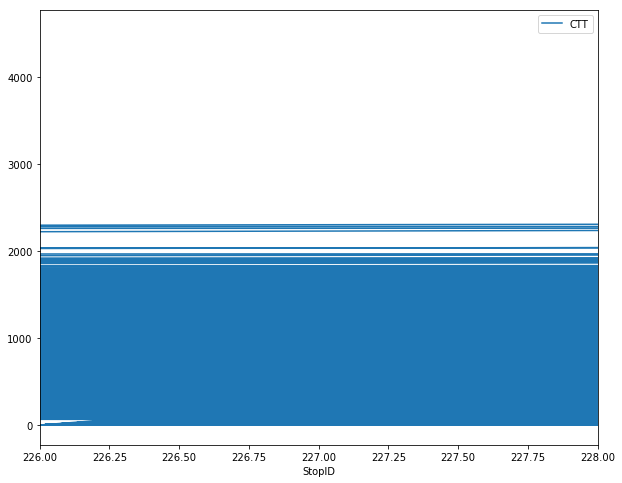

In [29]:
a=df_lin_reg.plot(kind='line', x='StopID', y='CTT', figsize=(10, 8))

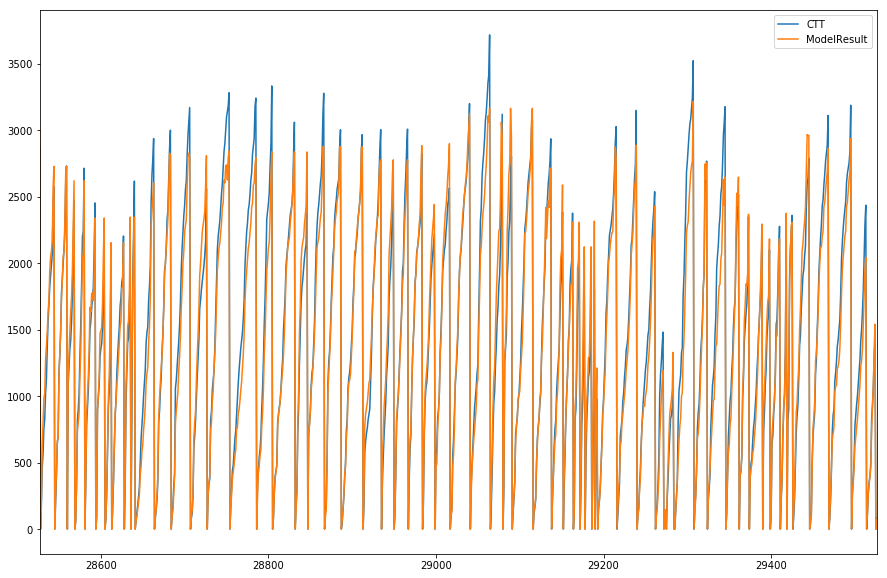

In [31]:
df_lin_reg.tail(1000).plot(y=["CTT", "ModelResult"], kind="line", figsize=(15,10))